In [3]:
from __future__ import annotations
import operator
from typing import TypedDict, List, Annotated, Literal
from langgraph.graph import START,END, StateGraph
from pydantic import BaseModel, Field
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.types import Send
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import os

In [ ]:
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

In [4]:
load_dotenv(override = True)
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
HUGGINGFACEHUB_API_TOKEN = os.getenv('HUGGINGFACEHUB_API_TOKEN')
GROQ_API_KEY=os.getenv('GROQ_API_KEY')

In [68]:
class Task(BaseModel):
    id: int
    title: str
    
    goal: str = Field(
        ...,
        description="One sentence describing what the reader should be able to do/understand after this section.",
    )
    bullets: List[str] = Field(
        ...,
        min_length=3,
        max_length=5,
        description="3–5 concrete, non-overlapping subpoints to cover in this section.",
    )
    target_words: int = Field(
        ...,
        description="Target word count for this section (120–450).",
    )
    section_type: Literal[
        "intro", "core", "examples", "checklist", "common_mistakes", "conclusion"
    ] = Field(
        ...,
        description="Use 'common_mistakes' exactly once in the plan.",
    )
    

In [69]:
class Plan(BaseModel):
    blog_title: str
    audience: str = Field(..., description = 'Who is this blog for?')
    tone: str= Field(..., description = 'Writing tone of the blog (e.g., informative, entertaining, etc.)')
    tasks: List[Task]

In [70]:
class State(TypedDict):
    topic: str
    plan: Plan
    sections: Annotated[List[str], operator.add]
    final: str

In [71]:
from langchain_ollama import OllamaLLM
model = OllamaLLM(                            
    model="llama3",
    temperature=0.3
)

In [72]:
llm1 = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    GOOGLE_API_KEY= GOOGLE_API_KEY,
    temperature = 0.6
)

Unexpected argument 'GOOGLE_API_KEY' provided to ChatGoogleGenerativeAI.


In [ ]:
llm2 = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model_name='llama-3.1-70b-versatile'
)

In [6]:
from groq import Groq

client = Groq(api_key=GROQ_API_KEY)
print(client.models.list())

ModelListResponse(data=[Model(id='qwen/qwen3-32b', created=1748396646, object='model', owned_by='Alibaba Cloud', active=True, context_window=131072, public_apps=None, max_completion_tokens=40960), Model(id='meta-llama/llama-4-scout-17b-16e-instruct', created=1743874824, object='model', owned_by='Meta', active=True, context_window=131072, public_apps=None, max_completion_tokens=8192), Model(id='canopylabs/orpheus-arabic-saudi', created=1765926439, object='model', owned_by='Canopy Labs', active=True, context_window=4000, public_apps=None, max_completion_tokens=50000), Model(id='llama-3.1-8b-instant', created=1693721698, object='model', owned_by='Meta', active=True, context_window=131072, public_apps=None, max_completion_tokens=131072), Model(id='whisper-large-v3-turbo', created=1728413088, object='model', owned_by='OpenAI', active=True, context_window=448, public_apps=None, max_completion_tokens=448), Model(id='canopylabs/orpheus-v1-english', created=1766186316, object='model', owned_by=

In [74]:
# response = llm2.invoke('what are multiagent systems explain in short')
# response

In [ ]:
client = HuggingFaceEndpoint(
    repo_id="openai/gpt-oss-20b",
    huggingfacehub_api_token=HUGGINGFACEHUB_API_TOKEN,
    max_new_tokens=512,
    temperature=0.7,
)
llm3 = ChatHuggingFace(llm = client)

In [76]:
# response = llm.invoke('what are multiagent systems explain in short')
# response

In [78]:
# Planner Node 

def orchestrator(state: State) -> dict:
    
    plan = llm1.with_structured_output(Plan).invoke(
        [
            SystemMessage(
                content = (
                    "You are a senior technical writer and developer advocate. Your job is to produce a "
                    "highly actionable outline for a technical blog post.\n\n"
                    "Hard requirements:\n"
                    "- Create 4–6 sections (tasks) that fit a technical blog.\n"
                    "- Each section must include:\n"
                    "  1) goal (1 sentence: what the reader can do/understand after the section)\n"
                    "  2) 3–5 bullets that are concrete, specific, and non-overlapping\n"
                    "  3) target word count (120–450)\n"
                    "- Include EXACTLY ONE section with section_type='common_mistakes'.\n\n"
                    "Make it technical (not generic):\n"
                    "- Assume the reader is a developer; use correct terminology.\n"
                    "- Prefer design/engineering structure: problem → intuition → approach → implementation → "
                    "trade-offs → testing/observability → conclusion.\n"
                    "- Bullets must be actionable and testable (e.g., 'Show a minimal code snippet for X', "
                    "'Explain why Y fails under Z condition', 'Add a checklist for production readiness').\n"
                    "- Explicitly include at least ONE of the following somewhere in the plan (as bullets):\n"
                    "  * a minimal working example (MWE) or code sketch\n"
                    "  * edge cases / failure modes\n"
                    "  * performance/cost considerations\n"
                    "  * security/privacy considerations (if relevant)\n"
                    "  * debugging tips / observability (logs, metrics, traces)\n"
                    "- Avoid vague bullets like 'Explain X' or 'Discuss Y'. Every bullet should state what "
                    "to build/compare/measure/verify.\n\n"
                    "Ordering guidance:\n"
                    "- Start with a crisp intro and problem framing.\n"
                    "- Build core concepts before advanced details.\n"
                    "- Include one section for common mistakes and how to avoid them.\n"
                    "- End with a practical summary/checklist and next steps.\n\n"
                    "Output must strictly match the Plan schema."
                    )
                ),
            HumanMessage(content = f"Topic: {state['topic']}"),
        ]
    )
    return {'plan': plan}

In [79]:
# To find out the no.of sections\task that the planner Node as planned

def fanout(state: State):
    return [Send('worker',{'task':task,'topic':state['topic'],'plan': state['plan']}) for task in state['plan'].tasks]

In [80]:
def worker(payload: dict) -> dict:
    task = payload['task']
    topic = payload['topic']
    plan = payload['plan']
    
    bullets_text = "\n- "+"\n- ".join(task.bullets)
    
    section_md = model.invoke(
        [
            SystemMessage(
                content = ("You are a senior technical writer and developer advocate. Write ONE section of a technical blog post in Markdown.\n\n"
                "Hard constraints:\n"
                "- Follow the provided Goal and cover ALL Bullets in order (do not skip or merge bullets).\n"
                "- Stay close to the Target words (±15%).\n"
                "- Output ONLY the section content in Markdown (no blog title H1, no extra commentary).\n\n"
                "Technical quality bar:\n"
                "- Be precise and implementation-oriented (developers should be able to apply it).\n"
                "- Prefer concrete details over abstractions: APIs, data structures, protocols, and exact terms.\n"
                "- When relevant, include at least one of:\n"
                "  * a small code snippet (minimal, correct, and idiomatic)\n"
                "  * a tiny example input/output\n"
                "  * a checklist of steps\n"
                "  * a diagram described in text (e.g., 'Flow: A -> B -> C')\n"
                "- Explain trade-offs briefly (performance, cost, complexity, reliability).\n"
                "- Call out edge cases / failure modes and what to do about them.\n"
                "- If you mention a best practice, add the 'why' in one sentence.\n\n"
                "Markdown style:\n"
                "- Start with a '## <Section Title>' heading.\n"
                "- Use short paragraphs, bullet lists where helpful, and code fences for code.\n"
                "- Avoid fluff. Avoid marketing language.\n"
                "- If you include code, keep it focused on the bullet being addressed.\n"
                    )
                ),
            HumanMessage(
                content = (
                    f"Blog: {plan.blog_title}\n"
                    f"Audience: {plan.audience}\n"
                    f"Tone: {plan.tone}\n"
                    f"Topic: {topic}\n\n"
                    f"Section: {task.title}\n"
                    f"Section type: {task.section_type}\n"
                    f"Goal: {task.goal}\n"
                    f"Target words: {task.target_words}\n"
                    f"Bullets:{bullets_text}\n"
                )
            )
        ]
    ).strip()
    print(section_md)
    
    return {'sections': [section_md]}
    

In [81]:
from pathlib import Path

def reducer(state: State) -> dict:
    
    title = state['plan'].blog_title
    body = "\n\n".join(state["sections"]).strip()
    
    final_md = f"# {title}\n\n{body}\n"
    filename = "".join(c if c.isalnum() or c in (" ", "_", "-") else "" for c in title)
    filename = filename.strip().lower().replace(" ", "_") + ".md"
    Path(filename).write_text(final_md, encoding="utf-8")
    
    return {'final': final_md}

In [82]:
graph = StateGraph(State)
graph.add_node('orchestrator',orchestrator)
graph.add_node('worker',worker)
graph.add_node('reducer',reducer)


graph.add_edge(START,'orchestrator')
graph.add_conditional_edges('orchestrator',fanout,['worker'])
graph.add_edge('worker','reducer')
graph.add_edge('reducer',END)


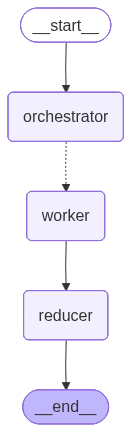

In [83]:
app = graph.compile()
app

In [61]:
out = app.invoke({'topic':'write a blog on Self Attention in Transformers','sections':[]})

## Beyond Single Head: The Power of Multi-Head Attention

Multi-Head Attention (MHA) is a crucial component in the Transformer architecture that enables the model to capture diverse relationships between input elements. Unlike single-head attention, which focuses on a single representation subspace, MHA allows the model to jointly attend to information from different subspaces at different positions.

To understand how MHA works, let's break it down into its constituent parts. In traditional self-attention mechanisms, the query (Q), key (K), and value (V) vectors are typically computed separately. In MHA, these vectors are split into multiple heads, each attending to a different representation subspace. This is achieved by performing parallel attention computations on each head, followed by concatenation and linear projection of the outputs.

The benefits of MHA become apparent when considering its ability to capture varied aspects of relationships between input elements. For instance,